import packages
------------------

Some packages are installed automatically if you use Anaconda. As pytorch is used here, you are expected to install that in your machine. 

In [13]:
from __future__ import print_function, division
import os, random, time, copy
from sklearn.metrics import confusion_matrix
import seaborn as sn
from operator import itemgetter 
import pandas as pd
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import torch

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 <a list of 48 Text xticklabel objects>)

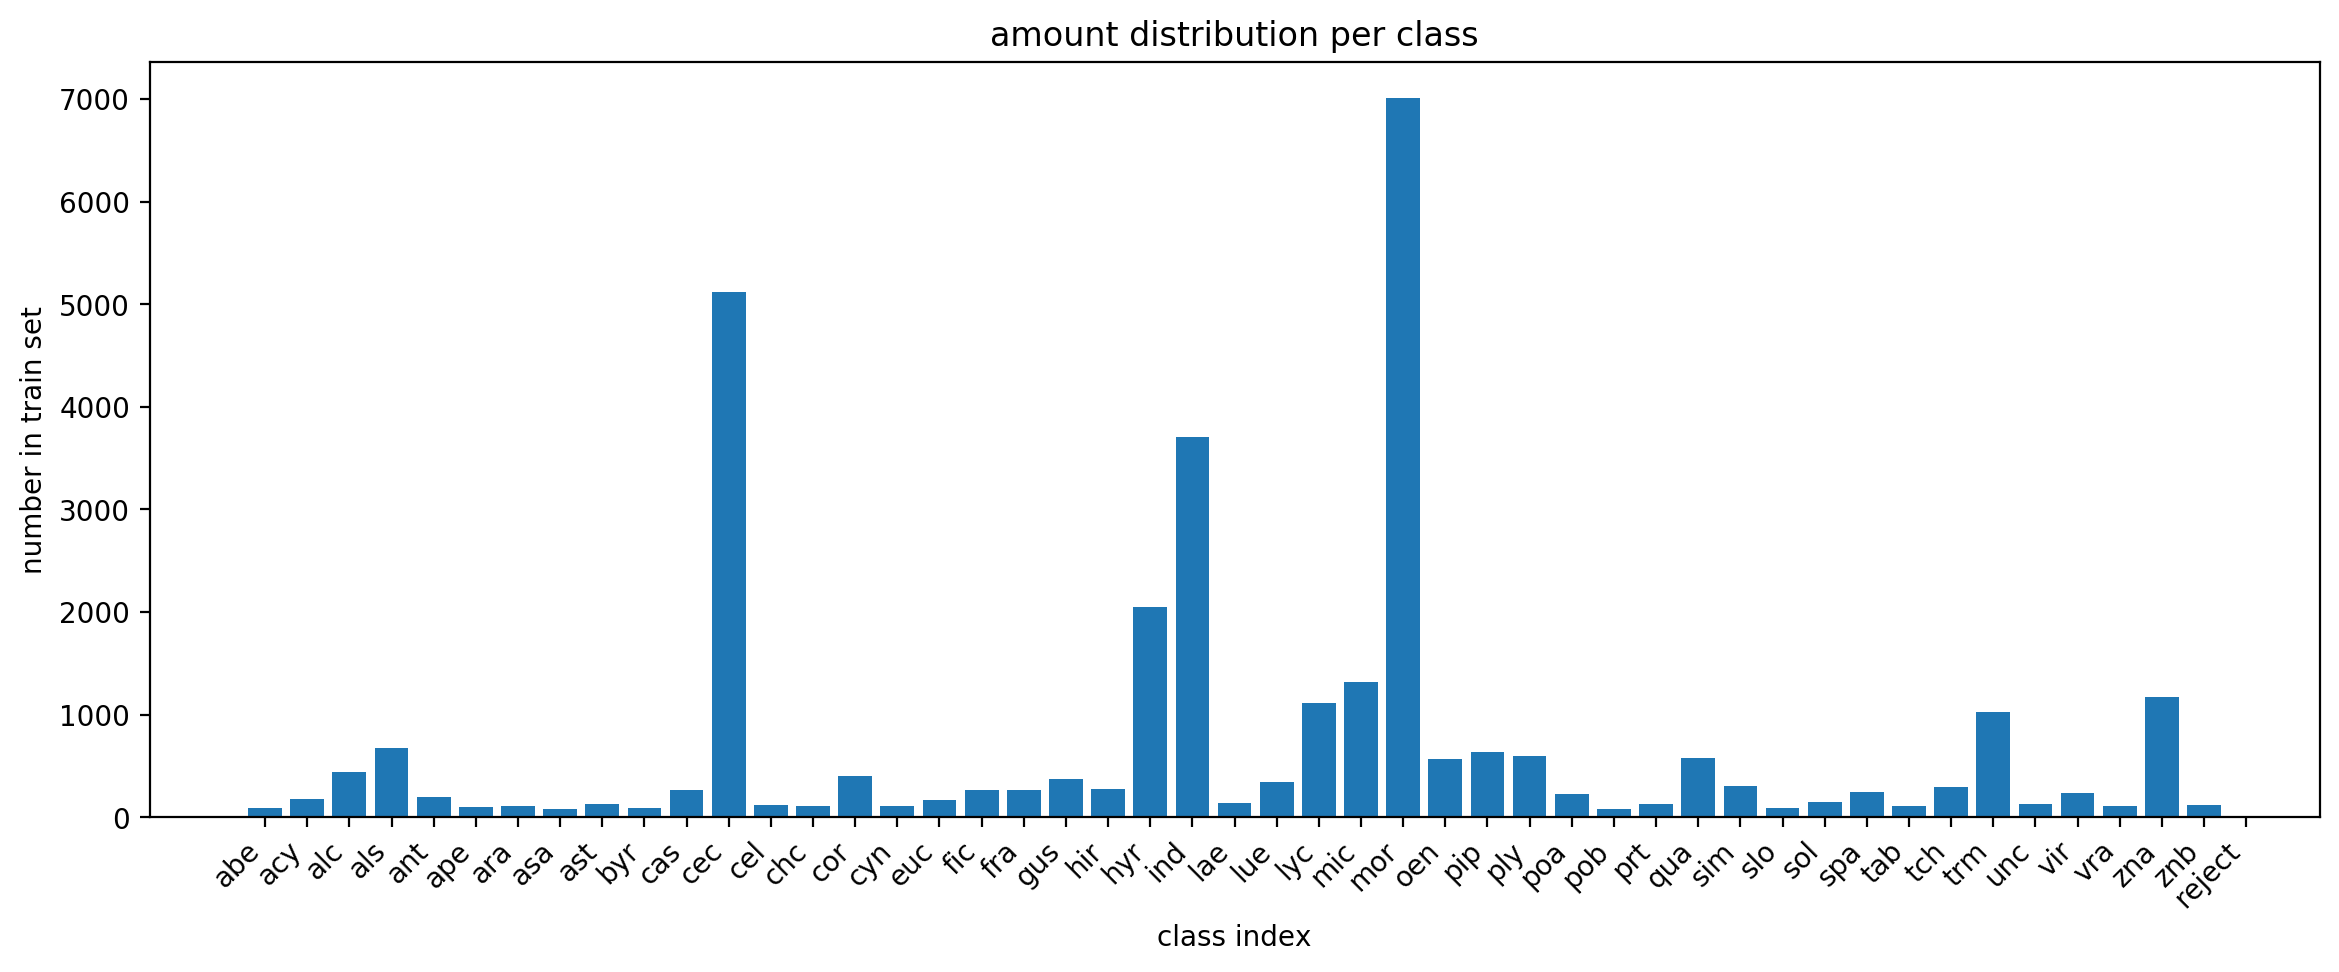

In [14]:
with open('dbinfo_cls_noRejectClass.plk', 'rb') as handle:
    dbinfo = pickle.load(handle)

tmpval = -np.asarray(dbinfo['perClassCount'])
sort_index = np.argsort(tmpval)
top25indices = sort_index[1:26]
top25indices = torch.from_numpy(top25indices)
top25indices = top25indices.sort().values

    
plt.figure(figsize=(14, 5), dpi=200, facecolor='w', edgecolor='k') # figsize -- inch-by-inch

plt.bar(list(range(47)), dbinfo['perClassCount'])
plt.title('amount distribution per class')
plt.xlabel('class index')
plt.ylabel('number in train set')


plt.xticks(list(range(48)), dbinfo['meta'], size=10)
plt.xticks(rotation=45, ha='right')

#ax.tick_params(axis='both', which='major', labelsize=17)

In [15]:
save_to_folder = './result' # experiment directory, used for reading the init model


filename = path.join(save_to_folder, 'step008_clsGTMaskPadNoRej_P001_resnet.plk')    
with open(filename, 'rb') as handle:
    result_model1 = pickle.load(handle)
    
filename = path.join(save_to_folder, 'step008_clsGTMaskPadNoRej_P003_resnet_wSqrtInvFreq.plk')    
with open(filename, 'rb') as handle:
    result_model2 = pickle.load(handle)

all-47
--

In [16]:
accDict = {}

totalClassNum = len(dbinfo['perClassCount'])
A = result_model1['grndLabel_noReject']
B = result_model1['predLabel_noReject']
accDict['accPerClass_model1'] = [0.0]*totalClassNum
accPerClass_verify = [0.0]*totalClassNum
for i in range(A.shape[0]):
    curClsIdx = A[i]
    curClsIdx = int(curClsIdx.numpy())
    predClsIdxPred = B[i]
    predClsIdxPred = int(predClsIdxPred.numpy())
    accDict['accPerClass_model1'][curClsIdx] += float(curClsIdx==predClsIdxPred)
    accPerClass_verify[curClsIdx] += 1

for i in range(totalClassNum):
    accDict['accPerClass_model1'][i] = accDict['accPerClass_model1'][i] * 1.0 / (accPerClass_verify[i]+0.00001)
    
    
    
A = result_model2['grndLabel_noReject']
B = result_model2['predLabel_noReject']
B = B[A!=47]
A = A[A!=47]
accDict['accPerClass_model2'] = [0.0]*totalClassNum
accPerClass_verify = [0.0]*totalClassNum
for i in range(A.shape[0]):
    curClsIdx = A[i]
    curClsIdx = int(curClsIdx.numpy())
    predClsIdxPred = B[i]
    predClsIdxPred = int(predClsIdxPred.numpy())
    accDict['accPerClass_model2'][curClsIdx] += float(curClsIdx==predClsIdxPred)
    accPerClass_verify[curClsIdx] += 1

for i in range(totalClassNum):
    accDict['accPerClass_model2'][i] = accDict['accPerClass_model2'][i] * 1.0 / (accPerClass_verify[i]+0.00001)
      

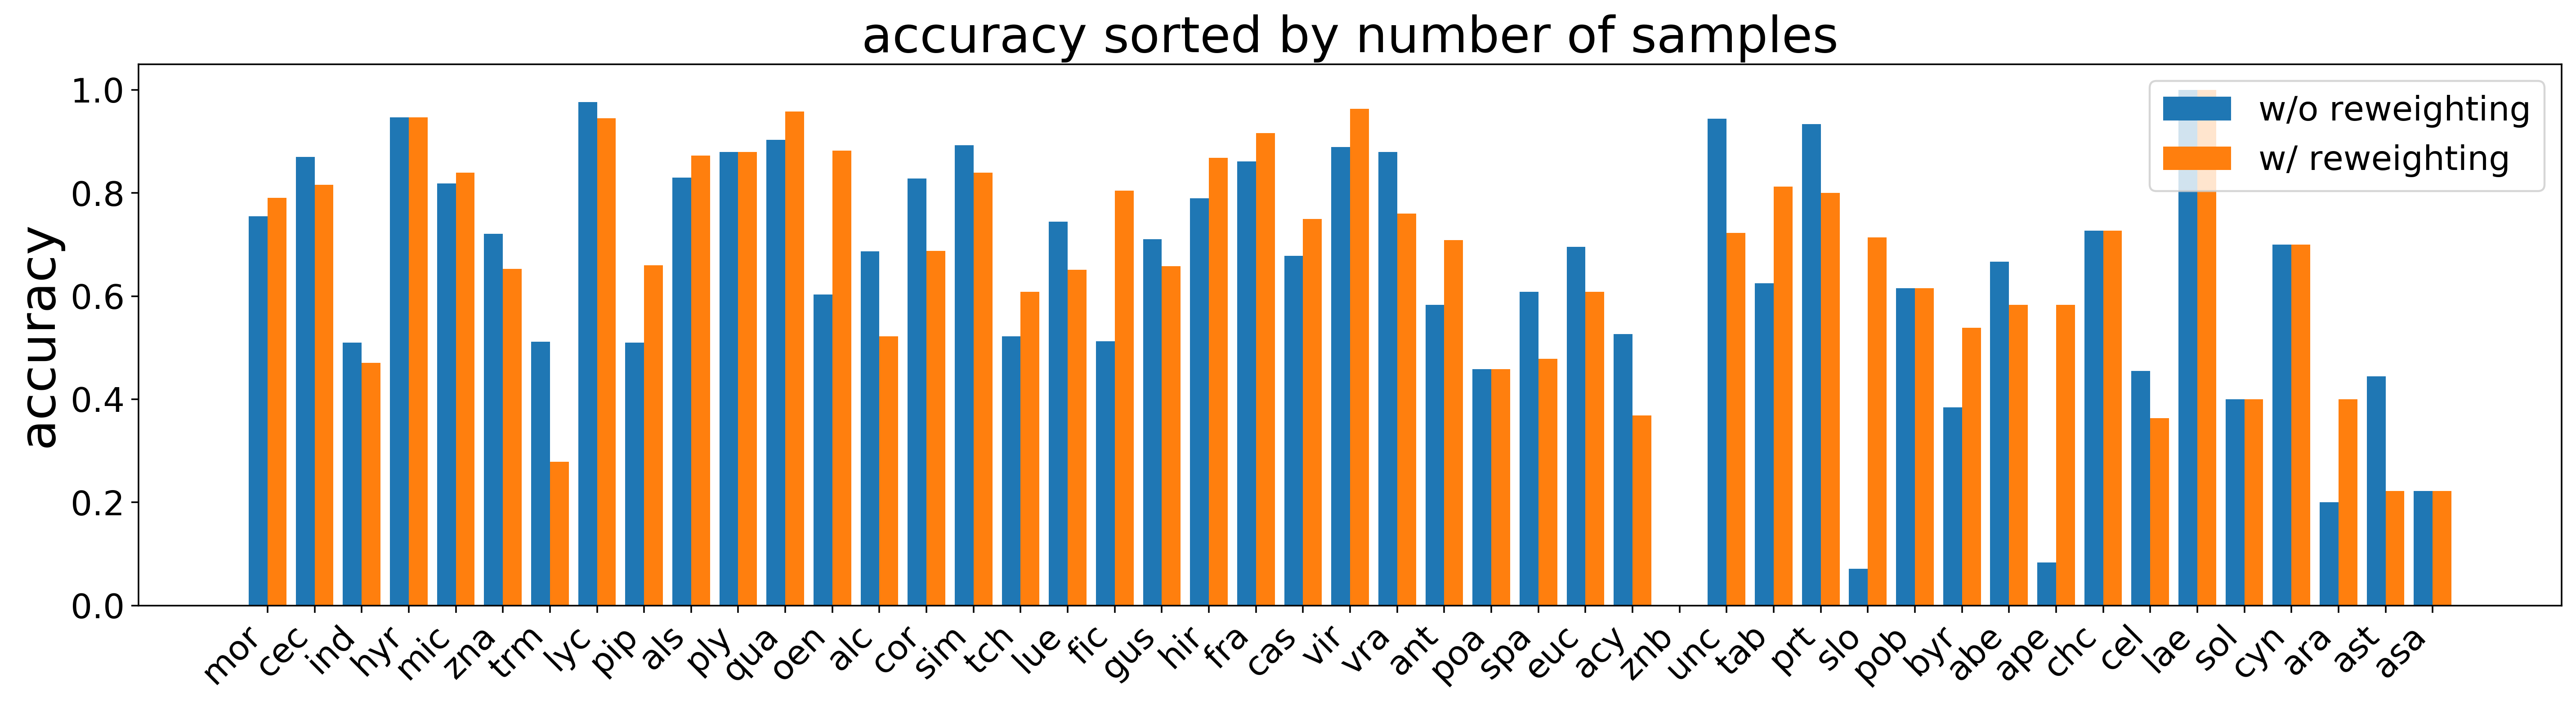

In [17]:
tmpval = -np.asarray(accPerClass_verify)
#sort_index = np.argsort(tmpval)
sort_index = torch.from_numpy(tmpval)
sort_index = sort_index.sort().indices

nameList = itemgetter(*sort_index.numpy().tolist())(dbinfo['meta'])

tmp_num = itemgetter(*sort_index.numpy().tolist())(accPerClass_verify)
tmp_acc1 = itemgetter(*sort_index.numpy().tolist())(accDict['accPerClass_model1'])
tmp_acc2 = itemgetter(*sort_index.numpy().tolist())(accDict['accPerClass_model2'])


x = np.arange(len(sort_index))  # the label locations
width = 0.4  # the width of the bars


#plt.figure(figsize=(8, 4), dpi=200, facecolor='w', edgecolor='k') # figsize -- inch-by-inch

fig, ax = plt.subplots(1, sharex=True, figsize=(18,5), dpi=320)
rects1 = ax.bar(x - width/2, tmp_acc1, width, label='w/o reweighting')
#rects2 = ax.bar(x + width/2, tmp_acc2, width, label='w/ reweighting')
rects2 = ax.bar(x + width/2, tmp_acc2, width, label='w/ reweighting')


ax.set_ylabel('accuracy', size=25)
ax.set_title('accuracy sorted by number of samples', size=25)
ax.set_xticks(x)
ax.set_xticklabels(nameList, size=15)
ax.legend(fontsize=17)
plt.xticks(rotation=45, ha='right')

ax.tick_params(axis='both', which='major', labelsize=17)


fig.tight_layout()
plt.show()

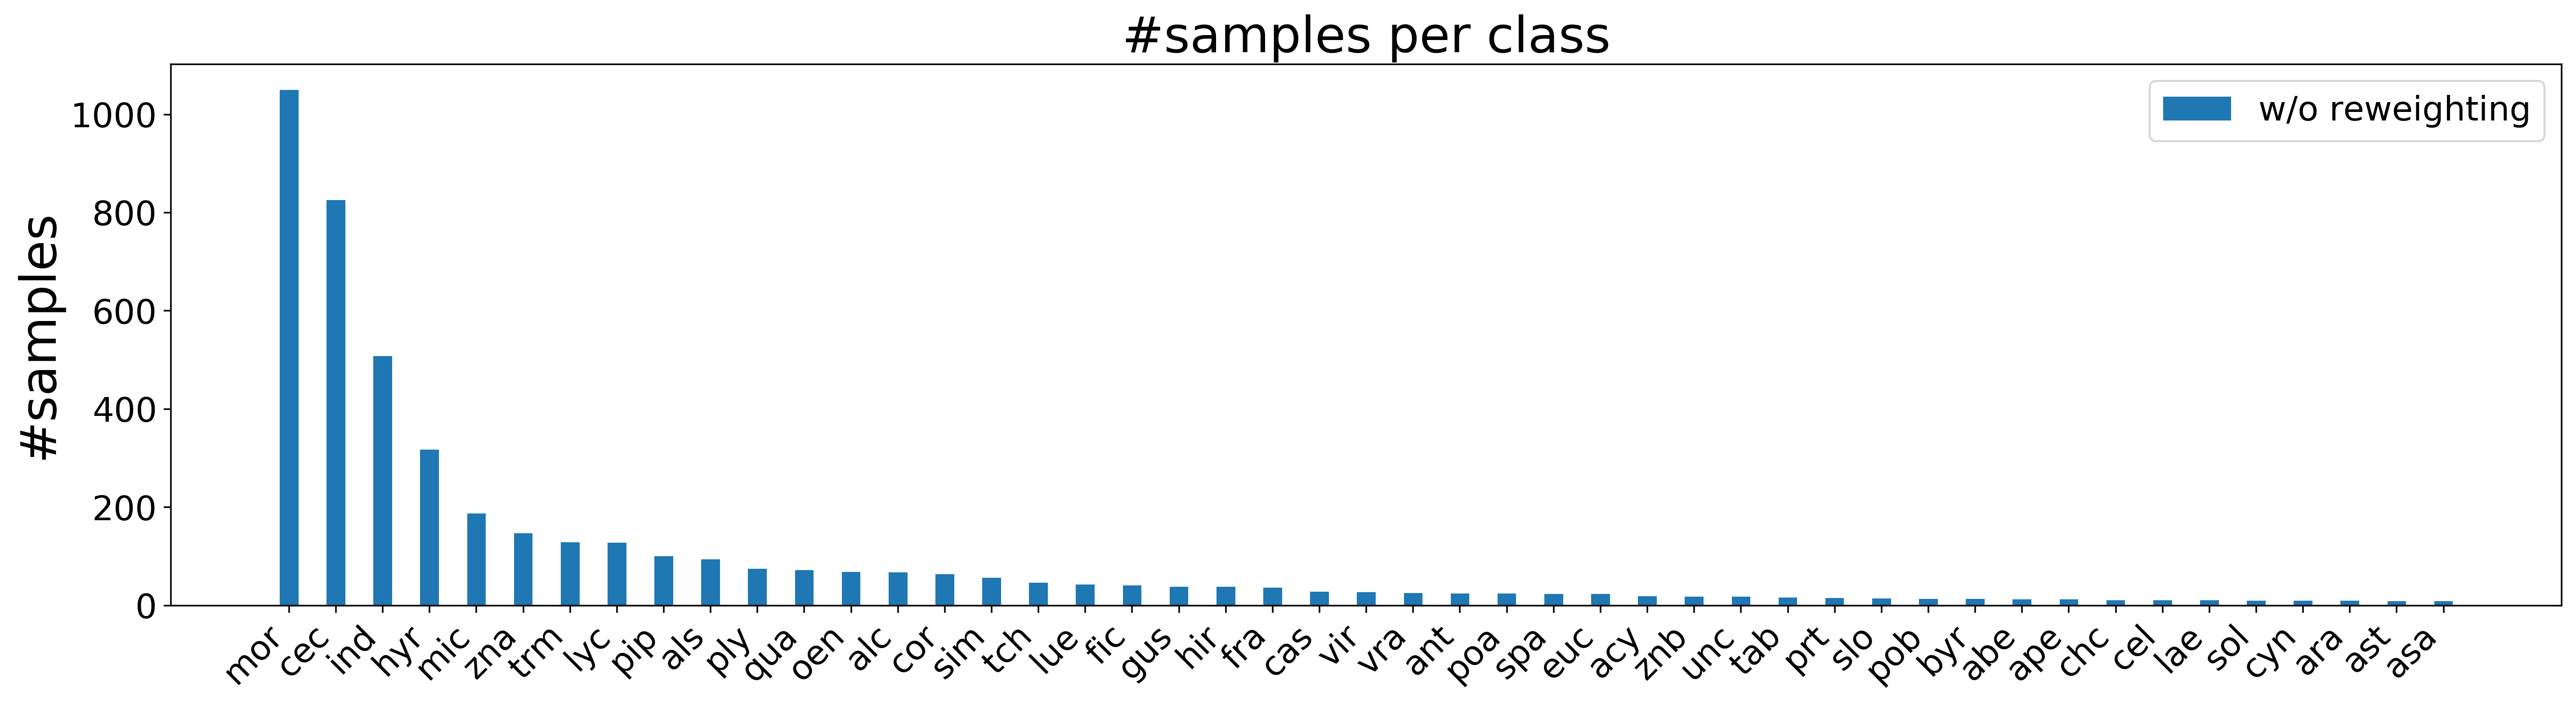

In [18]:
fig, ax = plt.subplots(1, sharex=True, figsize=(18,5), dpi=320)
rects = ax.bar(x, tmp_num, width, label='w/o reweighting')

ax.set_ylabel('#samples', size=25)
ax.set_title('#samples per class', size=25)
ax.set_xticks(x)
ax.set_xticklabels(nameList, size=15)
ax.legend(fontsize=17)
plt.xticks(rotation=45, ha='right')

ax.tick_params(axis='both', which='major', labelsize=17)


fig.tight_layout()
plt.show()

In [34]:
derek_namelist = list(nameList)
derek_perclsNum = list(tmp_num)
derek_acc_withoutReweighting = tmp_acc1
derek_acc_withReweighting = tmp_acc2

str_num = ''
for elm in derek_perclsNum:
    str_num += ',{:.4f}'.format(elm)

acc_without = ''
for elm in derek_acc_withoutReweighting:
    acc_without += ',{:.4f}'.format(elm)

acc_with = ''
for elm in derek_acc_withReweighting:
    acc_with += ',{:.4f}'.format(elm)


derek_csv = 'derek_csv_for_barchart.csv'
with open(derek_csv, 'w') as fn:
    fn.write('name,' + ','.join(derek_namelist)+'\n')
    fn.write('number,' + str_num[1:]+'\n')
    fn.write('acc_with_reweighting,' + acc_with[1:]+'\n')
    fn.write('acc_without_reweighting,' + acc_without[1:]+'\n')


In [33]:
derek_acc_withoutReweighting

(0.7552380880453515,
 0.8704600378878931,
 0.5098425096487695,
 0.9463722098936213,
 0.8181817744287821,
 0.721088386320518,
 0.5116278673156692,
 0.9765624237060606,
 0.5099999490000051,
 0.8297871457673249,
 0.8799998826666823,
 0.9027776523919927,
 0.6029410878027812,
 0.6865670617064087,
 0.8281248706054889,
 0.8928569834183958,
 0.5217390170132571,
 0.7441858734451456,
 0.5121949970256104,
 0.7105261288089134,
 0.7894734764543483,
 0.8611108719136467,
 0.6785711862245764,
 0.8888885596709039,
 0.8799996480001409,
 0.583333090277879,
 0.4583331423611907,
 0.6086953875237445,
 0.6956518714557081,
 0.5263155124655198,
 0.0,
 0.9444439197533779,
 0.6249996093752441,
 0.9333327111115259,
 0.0714285204081997,
 0.6153841420121985,
 0.38461508875762407,
 0.6666661111115741,
 0.08333326388894677,
 0.7272720661163036,
 0.45454504132268975,
 0.9999990909099173,
 0.3999996000004,
 0.6999993000007,
 0.1999998000002,
 0.44444395061783265,
 0.22222197530891633)

top-25
--

In [7]:
totalClassNum = 25

grndLabel_top25_model1 = result_model1['grndLabel_top25']
predLabel_top25_model1 = result_model1['predLabel_top25']
grndLabel_top25_model2 = result_model2['grndLabel_top25']
predLabel_top25_model2 = result_model2['predLabel_top25']

a = []
for i in range(len(grndLabel_top25_model1)):
    if int(grndLabel_top25_model1[i].item()) in top25indices:
        a += [i]

        
        
B_top25_model1 = predLabel_top25_model1[a]
A_top25_model1 = grndLabel_top25_model1[a]
B_top25_model2 = predLabel_top25_model2[a]
A_top25_model2 = grndLabel_top25_model2[a]



top25indicesList = top25indices.cpu().numpy().tolist()
for i in range(len(A_top25_model1)):
    elm = A_top25_model1[i]
    A_top25_model1[i] = top25indicesList.index(elm) 
    elm = A_top25_model2[i]
    A_top25_model2[i] = top25indicesList.index(elm)       

#print(A_top25.shape, B_top25.shape)
A_top25_model1 = A_top25_model1.numpy()
B_top25_model1 = B_top25_model1.numpy()
A_top25_model2 = A_top25_model2.numpy()
B_top25_model2 = B_top25_model2.numpy()

# accList = A_top25-B_top25
# accList = (accList==0).astype(np.float32)
# acc = accList.mean()
# print(acc)

nameList = itemgetter(*top25indices.numpy().tolist())(dbinfo['meta'])
numPerCls = itemgetter(*top25indices.numpy().tolist())(accPerClass_verify)

In [8]:
accDict = {}
accDict['accPerClass_model1'] = [0.0]*totalClassNum
accPerClass_verify_top25 = [0.0]*totalClassNum
for i in range(A_top25_model1.shape[0]):
    curClsIdx = A_top25_model1[i]
    curClsIdx = int(curClsIdx)
    predClsIdxPred = B_top25_model1[i]
    predClsIdxPred = int(predClsIdxPred)
    accDict['accPerClass_model1'][curClsIdx] += float(curClsIdx==predClsIdxPred)
    accPerClass_verify_top25[curClsIdx] += 1

for i in range(totalClassNum):
    accDict['accPerClass_model1'][i] = accDict['accPerClass_model1'][i] * 1.0 / (accPerClass_verify_top25[i]+0.00001)
    

    
    

accDict['accPerClass_model2'] = [0.0]*totalClassNum
for i in range(A_top25_model2.shape[0]):
    curClsIdx = A_top25_model2[i]
    curClsIdx = int(curClsIdx)
    predClsIdxPred = B_top25_model2[i]
    predClsIdxPred = int(predClsIdxPred)
    accDict['accPerClass_model2'][curClsIdx] += float(curClsIdx==predClsIdxPred)

for i in range(totalClassNum):
    accDict['accPerClass_model2'][i] = accDict['accPerClass_model2'][i] * 1.0 / (accPerClass_verify_top25[i]+0.00001)
    

In [9]:
tmpval = -np.asarray(list(numPerCls))
sort_index = torch.from_numpy(tmpval)
sort_index = sort_index.sort().indices.numpy().tolist()

nameList_sorted = itemgetter(*sort_index)(nameList)
numPerCls_sorted = itemgetter(*sort_index)(numPerCls) 
acc_mode1_sorted = itemgetter(*sort_index)(accDict['accPerClass_model1'])
acc_mode2_sorted = itemgetter(*sort_index)(accDict['accPerClass_model2'])

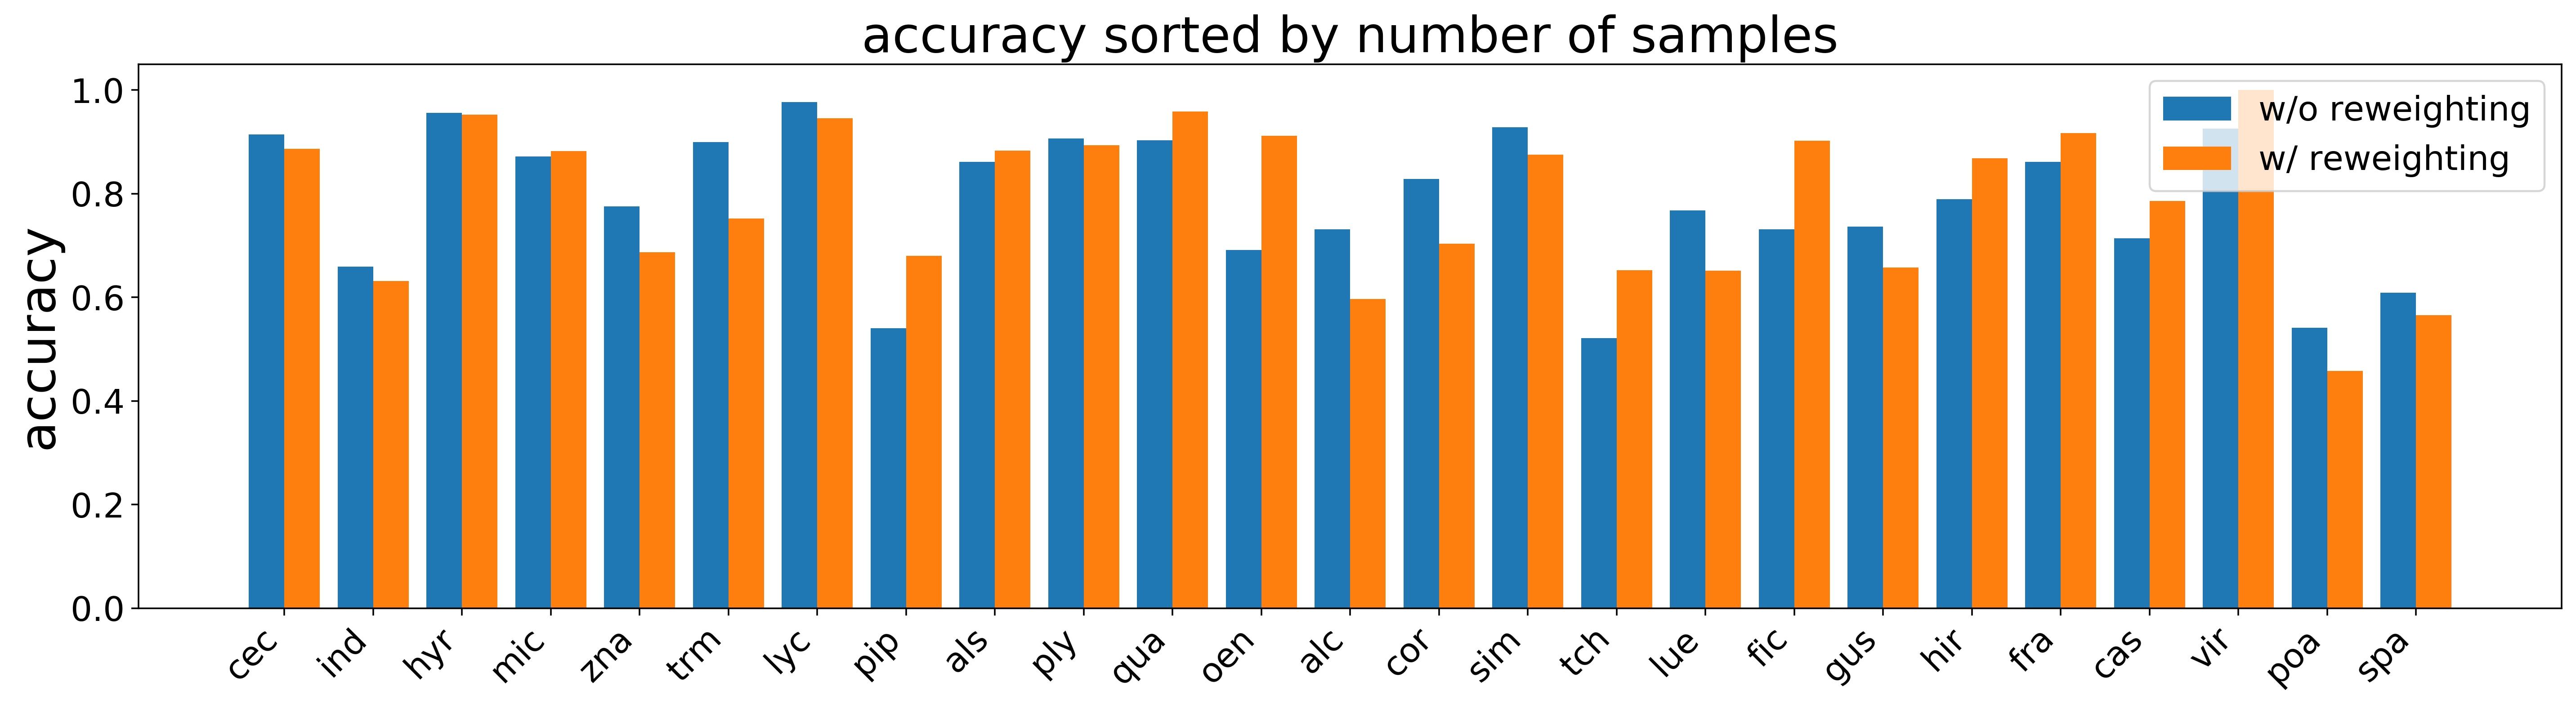

In [10]:
x = np.arange(len(nameList_sorted))  # the label locations
width = 0.4  # the width of the bars


fig, ax = plt.subplots(1, sharex=True, figsize=(18,5), dpi=320)
rects1 = ax.bar(x - width/2, acc_mode1_sorted, width, label='w/o reweighting')
#rects2 = ax.bar(x + width/2, acc_mode2_sorted, width, label='w/ reweighting')
rects3 = ax.bar(x + width/2, acc_mode2_sorted, width, label='w/ reweighting')


ax.set_ylabel('accuracy', size=25)
ax.set_title('accuracy sorted by number of samples', size=25)
ax.set_xticks(x)
ax.set_xticklabels(nameList_sorted, size=15)
ax.legend(fontsize=17)
plt.xticks(rotation=45, ha='right')

ax.tick_params(axis='both', which='major', labelsize=17)


fig.tight_layout()
plt.show()

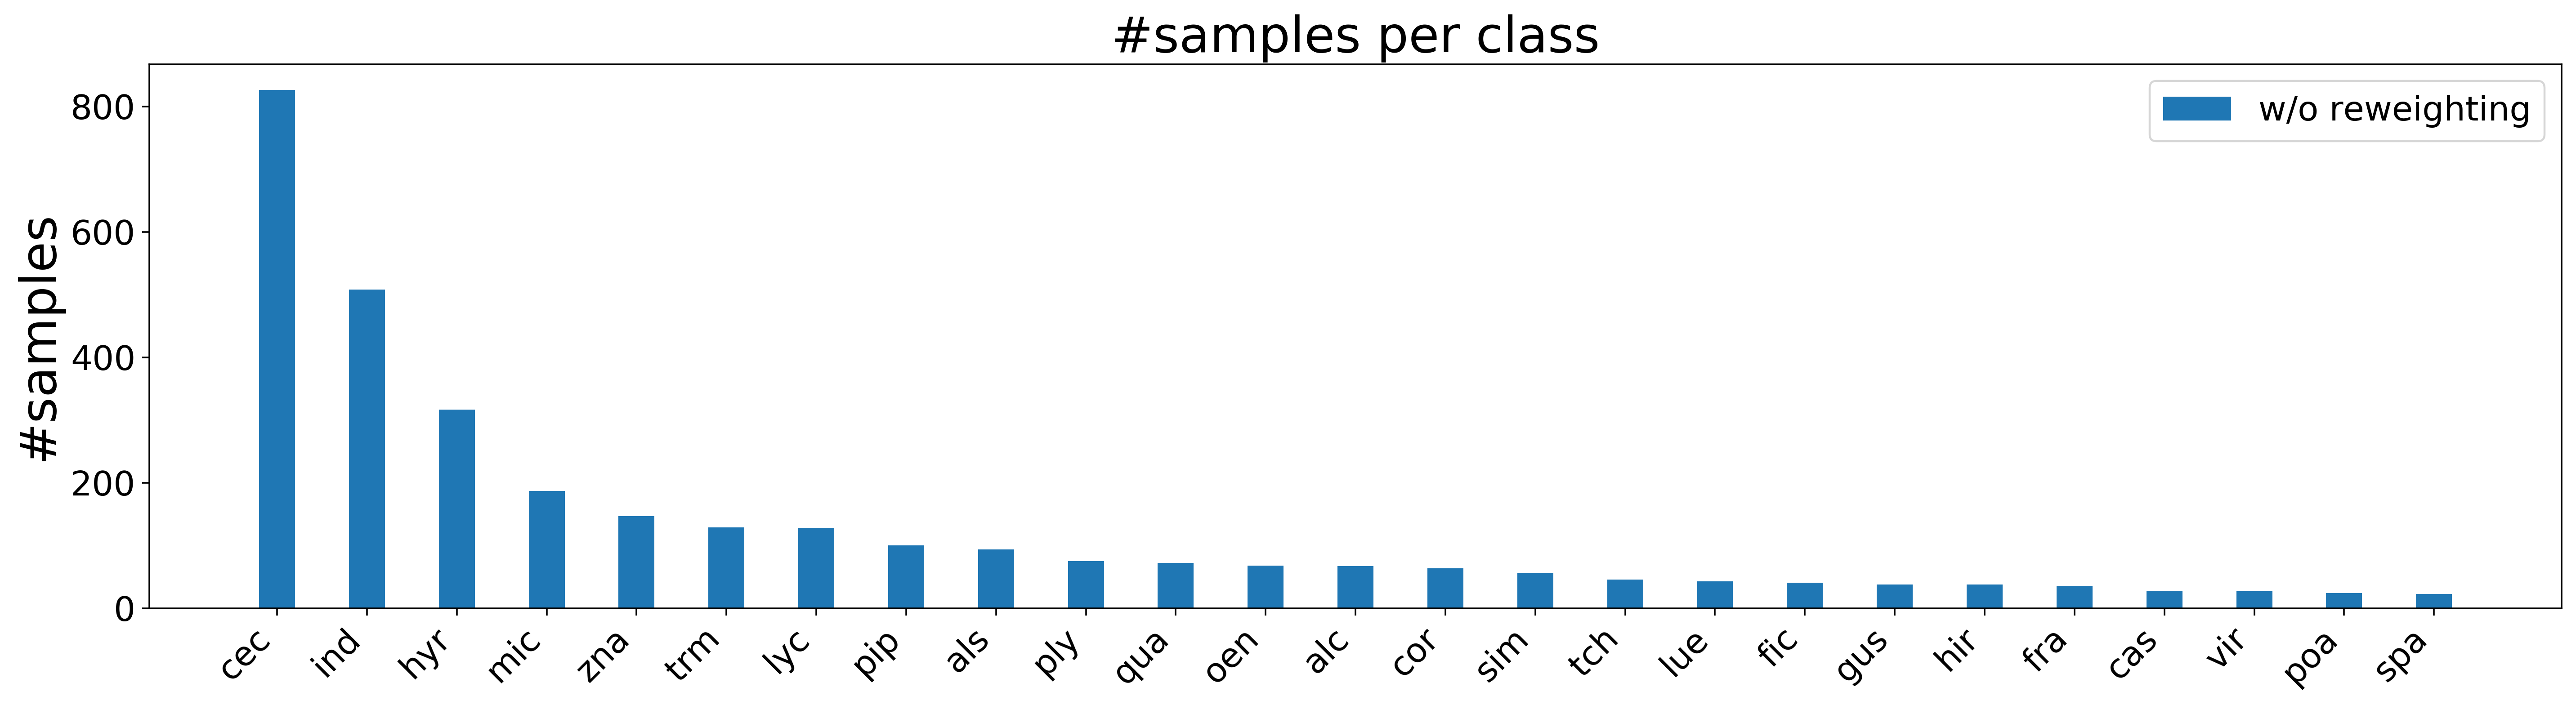

In [11]:
x = np.arange(len(numPerCls_sorted))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(1, sharex=True, figsize=(18,5), dpi=320)
rects = ax.bar(x, numPerCls_sorted, width, label='w/o reweighting')

ax.set_ylabel('#samples', size=25)
ax.set_title('#samples per class', size=25)
ax.set_xticks(x)
ax.set_xticklabels(nameList_sorted, size=15)
ax.legend(fontsize=17)
plt.xticks(rotation=45, ha='right')

ax.tick_params(axis='both', which='major', labelsize=17)


fig.tight_layout()
plt.show()

bar chart
-----

https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py



Leaving Blank
-----